## ImageMagick processing

remove white borders and save as .png
http://www.imagemagick.org/Usage/masking/#bg_remove

In [21]:
import subprocess
import os

box_dir = 'shelves'

img_dir = os.path.join('img', box_dir)


files = os.listdir(img_dir)
for file in files:
    
    # set input and output file names
    file = os.path.join(img_dir, file)
    outfile = file[:file.rindex('.')] + '.png'
    
    # call ImageMagick via shell command
    cmd = f'convert {file} -bordercolor white -border 1x1 -alpha set -channel RGBA -fuzz 20% -fill none -floodfill +0+0 white -shave 1x1 {outfile}'
    os.system(cmd)

## overlay images

In [589]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
import numpy as np
%matplotlib inline
from PIL import Image, ImageFilter

In [620]:
# Load images
box_path = os.path.join('img', 'Froot_Loops', 'b.png')
box = Image.open(box_path)
shelf_path = os.path.join('img', 'shelves', '106420241-1583179975068photo-mar-02-11-18-45-am.png')
shelf = Image.open(shelf_path)

def resize_image(box_image, bg_image):
    """Resize image by random amount"""
    while True:
        rand = np.random.uniform(0.5, 5)
        r1 = int(rand*box_image.size[0])
        r2 = int(rand*box_image.size[1])
        if r1 < bg_image.size[0] and r2 < bg_image.size[1]:
            break
    return box_image.resize((r1,r2))

def tweak_color(image):
    """Tweak color by a small and random amount."""
    px = np.array(image)
    px[:,:,0] = px[:,:,0]*np.random.uniform(0.6,1)
    px[:,:,1] = px[:,:,1]*np.random.uniform(0.6,1)
    px[:,:,2] = px[:,:,2]*np.random.uniform(0.6,1)
    return Image.fromarray(px)

def blur(image):
    """Blue image by random amount. Determine blur magnitude using
    pareto distribution so that large blurs are rare"""
    blur_rad = np.min([np.random.pareto(2), 2])
    return box.filter(ImageFilter.GaussianBlur(radius=blur_rad))

box = resize_image(box, shelf)
box = tweak_color(box)
box = blur(box)

In [621]:
def make_perspective_coeffs(pa,pb):
    """Determines coefficients to be used in nonlinear perpective transformation"""
    matrix = []
    for p1,p2 in zip(pa,pb):
        matrix.append([p1[0],p1[1],1,0,0,0,-p2[0]*p1[0],-p2[0]*p1[1]])
        matrix.append([0,0,0,p1[0],p1[1],1,-p2[1]*p1[0],-p2[1]*p1[1]])

    A = np.matrix(matrix,dtype=np.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T*A)*A.T,B)
    return np.array(res).reshape(8)


# perspective transformation
r = np.random.uniform()
if r < 0.5:
    width_shift = width*np.random.uniform(0.0,0.2)
    height_shift = 0
else:
    width_shift = 0
    height_shift = height*np.random.uniform(0.0,0.2)
#print((width_shift,height_shift))
r = np.random.uniform()
if r < 0.5:
    coeffs = make_perspective_coeffs([(0,0), (width,height_shift), (width_shift,height), (width-width_shift,height-height_shift)],
        [(0,0), (width,0), (0,height), (width,height)])
else:
    coeffs = make_perspective_coeffs([(width_shift,height_shift), (width-width_shift,0), (0,height-height_shift), (width,height)],
        [(0,0), (width,0), (0,height), (width,height)])

box = box.transform((width,height),Image.PERSPECTIVE,coeffs,Image.BICUBIC)

# crop to alpha
box = box.crop(box.getbbox())

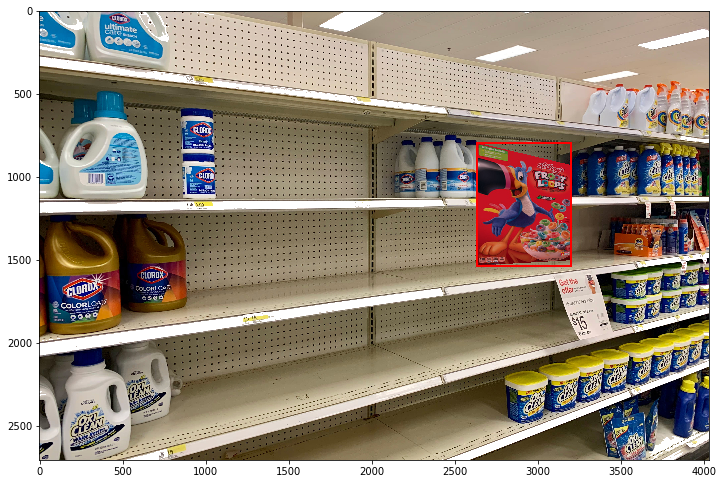

In [622]:
# set box location
xpos = int(np.floor(np.random.uniform(0, shelf.size[0]-box.size[0])))
ypos = int(np.floor(np.random.uniform(0, shelf.size[1]-box.size[1])))

# define label
label = [xpos, ypos, shelf.size[0]-box.size[0], shelf.size[1]-box.size[1]]

# superimpose
shelf.paste(box, (xpos,ypos), box) # what to paste, coords, mask where if transparent then alpha channel is mask

fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(np.array(shelf))
rect = patches.Rectangle((xpos,ypos), box.size[0], box.size[1], linewidth=2, edgecolor='r',facecolor='none')
ax.add_patch(rect);